# General Insights  

Let's visualize the dataset to see if there are some general (non-ML) insights we can get

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## Zip code efficiency (net emissions/sqrt_ft) for multi-home units:

In [8]:
data = pd.read_csv('./data/data_cleaned.csv')
print()

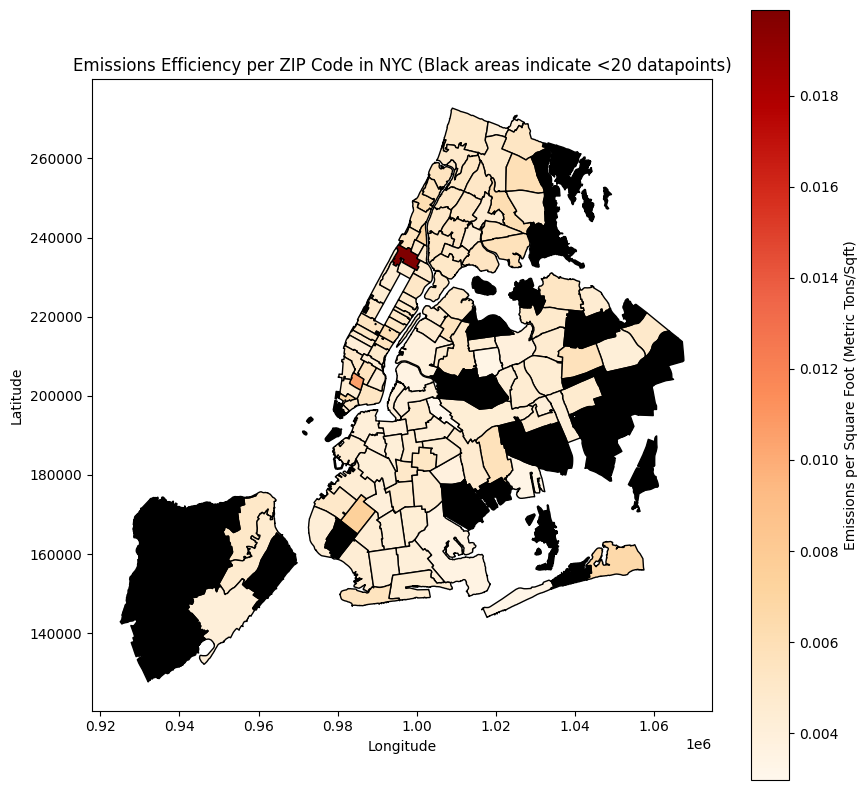

In [9]:
# Read the data
data = pd.read_csv('./data/data_cleaned.csv')

# Compute average emissions and total square footage per ZIP code
total_emissions_per_zip = data.groupby('postal_code')['net_emissions_metric_tons'].sum().reset_index()
total_sqft_per_zip = data.groupby('postal_code')['multifamily_housing_gross'].sum().reset_index()

# Merge the total emissions and total square footage data
emissions_sqft_data = pd.merge(total_emissions_per_zip, total_sqft_per_zip, on='postal_code')

# Compute emissions per square foot
emissions_sqft_data['emissions_per_sqft'] = emissions_sqft_data['net_emissions_metric_tons'] / emissions_sqft_data['multifamily_housing_gross']

# Load the shapefile
nyc_shape = gpd.read_file('./data/map_files/ZIP_CODE_040114.shp')

# Merge this data with the shapefile
emissions_sqft_merged = nyc_shape.merge(emissions_sqft_data, left_on='ZIPCODE', right_on='postal_code')

# Calculate data points per ZIP code and identify those with fewer than 20 data points
data_points_per_zip = data.groupby('postal_code').size().reset_index(name='data_points')
avg_emissions_with_counts = emissions_sqft_data.merge(data_points_per_zip, on='postal_code')
insufficient_data_zips_20 = avg_emissions_with_counts[avg_emissions_with_counts['data_points'] < 20]['postal_code'].tolist()

# Mark ZIP codes with insufficient data for visualization
emissions_sqft_merged['insufficient_data_20'] = emissions_sqft_merged['ZIPCODE'].isin(insufficient_data_zips_20)

# Plotting the efficiency data with axis labels
fig, ax = plt.subplots(figsize=(10, 10))
emissions_sqft_merged[~emissions_sqft_merged['insufficient_data_20']].plot(column='emissions_per_sqft', ax=ax, legend=True,
                                                                           legend_kwds={'label': "Emissions per Square Foot (Metric Tons/Sqft)"},
                                                                           cmap='OrRd', edgecolor='black')
emissions_sqft_merged[emissions_sqft_merged['insufficient_data_20']].plot(ax=ax, color='black', edgecolor='black')
plt.title("Emissions Efficiency per ZIP Code in NYC (Black areas indicate <20 datapoints)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
